In [58]:
# Visualize MNIST dataset
# Train MNIST
# Plot loss curve

In [3]:
import torch

In [4]:
from torchvision.datasets import MNIST

In [5]:
from torchvision import transforms

In [6]:
# TODO: talk more about what these compose options do
transf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, ), (1.0, ))])

In [8]:
train_set = MNIST(root='./data', train=True, transform=transf, download=False) # load training dataset

Processing...
Done!


In [9]:
train_set.train_data.shape # see dataset size

torch.Size([60000, 28, 28])

In [47]:
train_set.train_data[0];

In [66]:
# # To visualize the samples in dataset, let's use matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

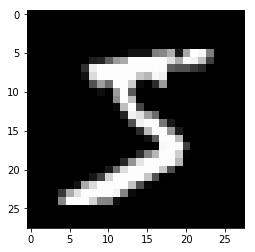

In [67]:
train_set.train_data[0].shape
plt.imshow(train_set.train_data[0], cmap='gray')


In [17]:
train_set.train_labels[0]

tensor(5)

In [18]:
test_set = MNIST(root='./data', train=False, transform=transf, download=True) # load training dataset

In [19]:
from torchvision.utils import make_grid # Combine images into a nice-looking grid layout

In [45]:
# first 10 samples combined together
# MNIST dataset doesn't have channel dimension, so we use unsqueeze to manually add it
def show(img):
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)), interpolation='nearest')
    plt.axis('off')
    plt.show()
    
print(train_set.train_data.shape)
print(train_set.train_data.unsqueeze(1).shape)
combined_image = make_grid(train_set.train_data[:10].unsqueeze(1))

torch.Size([60000, 28, 28])
torch.Size([60000, 1, 28, 28])


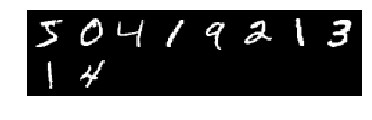

In [49]:
show(combined_image)

In [60]:
# Better way to visualize how good our model does
# For each target value (0-9), see how often our model gets it right
def confusion(model, n, dataset):
    conf = torch.zeros(n, n)
    model.eval() # Put model in evaluation mode
    for data, target in dataset:
        data = data.unsqueeze(1)
        output = model(data)
        _, pred = torch.max(output.data, 1)
        conf[target][pred[0]] += 1
        
    # Normalize
    for i in range(n):
        conf[i] = conf[i] / conf[i].sum()
        
    plt.matshow(conf.numpy())
    plt.show()
    
# A perfect model should show a diagonal white line

In [26]:
import torch.nn as nn
import torch.nn.functional as F

In [27]:
# Define our own CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(20 * 4 * 4, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x):
        # we can also use functional interface for Conv2d and pass in the weights and biases, useful in weight sharing scenario
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 20 * 4 * 4) # -1 means we only care about the size of the last dimension, and just merge the rest of the dimensions into one
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)

In [51]:
# Before we train the model, let's define the method for plotting the loss curve
import numpy as np

In [52]:
from torch import optim

In [53]:
from torch.optim import lr_scheduler

In [54]:
from torch.utils.data import TensorDataset, DataLoader

In [55]:
def train_model(model, train_set, test_set, nepochs):
    batch_size = 500
    # dataloader can help you get batched data and shuffle the data
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set)
    
    optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.5)
    
    model.train()
    
    for epoch in range(nepochs):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad() # This will zero out all the gradients for the model's parameters
            output = model(data) # This is a softmax output over the possible labels
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            
            if batch_idx % 50 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), float(loss)))

        model.eval()
        test_loss = 0.0
        correct = 0
        for data, target in test_loader:
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).data.item()
            
            _, pred = torch.max(output.data, 1)
            
            correct += (pred == target.data).sum()
            
        test_loss /= len(test_set)
        accuracy = float(correct)/len(test_set)
        print("Loss: {:.6f}".format(test_loss), "Accuracy: ", accuracy)
#         plot_loss_curve(epoch, nepochs, test_loss, accuracy)

In [56]:
model = CNN()

In [57]:
train_model(model, train_set, test_set, 10)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.308905
Train Epoch: 0 [25000/60000 (42%)]	Loss: 2.258031
Train Epoch: 0 [50000/60000 (83%)]	Loss: 1.857227
Loss: 1.013795 Accuracy:  0.7894
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.994386
Train Epoch: 1 [25000/60000 (42%)]	Loss: 0.372238
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.315495
Loss: 0.297112 Accuracy:  0.9106
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.353662
Train Epoch: 2 [25000/60000 (42%)]	Loss: 0.368623
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.213899
Loss: 0.207606 Accuracy:  0.9354
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.203597
Train Epoch: 3 [25000/60000 (42%)]	Loss: 0.179178
Train Epoch: 3 [50000/60000 (83%)]	Loss: 0.230627
Loss: 0.166928 Accuracy:  0.9464
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.129435
Train Epoch: 4 [25000/60000 (42%)]	Loss: 0.178167
Train Epoch: 4 [50000/60000 (83%)]	Loss: 0.126912
Loss: 0.128274 Accuracy:  0.9606
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.202354
Train Epoch: 5 [25000/60000 (42%)]	Loss: 0.118179
Train Epoch: 5 

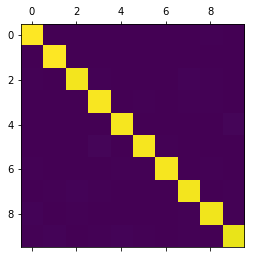

In [61]:
confusion(model, 10, test_set) # See confusion matrix

In [62]:
# Save model state as checkpoint, to be used later
torch.save(model.state_dict(), 'mnist.pth')

# Load model into another variable
new_model = CNN()
new_model.load_state_dict(torch.load('mnist.pth'))

In [63]:
new_model

CNN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [64]:
new_model

CNN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [65]:
model

CNN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [32]:
# TODO: for transfer learning, make sure the two linear layers are replaced